In [1]:
from typing import Any, List, Optional, Sequence, Tuple

In [2]:
pip install lightweight_mmm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.2/105.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.2.0 requires matplotlib>=3.7.1, but you have matplotlib 3.6.1 which is incompatible.


In [3]:
pip install numpyro==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: numpyro
    Found existing installation: numpyro 0.14.0
    Uninstalling numpyro-0.14.0:
      Successfully uninstalled numpyro-0.14.0


In [4]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.impute import KNNImputer

In [21]:
df = pd.read_csv("/education_marketing.csv")


In [22]:
X = df.drop("Enquiries",axis=1)
y = df["Enquiries"]

In [23]:
X

,Date,TV_Spends,Print_Spends,Radio_Spends,BTL_Spends,Search_Spends,Facebook_Spends,Youtube_Spends,Outdoor_Spends
0,2017-04-01,7.204000e+07,1.323467e+07,0.0,0,0.00,0.000000e+00,0.00,0
1,2017-05-01,6.549671e+07,1.717380e+07,0.0,0,0.00,0.000000e+00,0.00,0
2,2017-06-01,2.216630e+07,2.168018e+07,870480.0,0,0.00,0.000000e+00,0.00,0
3,2017-07-01,8.493681e+06,8.581722e+06,0.0,0,0.00,0.000000e+00,0.00,0
4,2017-08-01,5.359923e+07,2.787414e+07,0.0,0,0.00,0.000000e+00,0.00,0
...,...,...,...,...,...,...,...,...,...
71,2023-03-01,3.830963e+07,2.763172e+07,0.0,25051495,1022627.57,1.655860e+06,0.00,22764892
72,2023-04-01,0.000000e+00,4.802452e+06,0.0,0,270871.15,1.071992e+06,0.00,15633371
73,2023-05-01,0.000000e+00,7.541872e+06,0.0,0,177738.05,9.437913e+05,0.00,4000628
74,2023-06-01,2.085490e+07,4.030630e+06,0.0,0,242420.09,6.771782e+05,883099.15,3119494


In [24]:
channel_names = ['Tv','Print','BTL','Search', 'DV360', 'Facebook',  'Youtube','Outdoor']

In [25]:
# media_data_columns = ['TV_GRP','Print_Spends','BTL_Spends', 'Search_Clicks', 'DV360_Clicks',
#         'Facebook_Clicks',  'Youtube_Clicks' ,  'Outdoor_Spends' ]
media_data_columns = ['TV_Spends','Print_Spends','BTL_Spends','Search_Spends',
       'Facebook_Spends',  'Youtube_Spends', 'Outdoor_Spends' ]
costs_columns = ['TV_Spends','Print_Spends','BTL_Spends','Search_Spends',
       'Facebook_Spends',  'Youtube_Spends', 'Outdoor_Spends' ]
media_data = X[media_data_columns].to_numpy()
#extra_features = X[extra_features_column].to_numpy()
costs = X[costs_columns].to_numpy().sum(axis=0)
target = y.to_numpy()
media_data
costs



array([1.63843944e+09, 1.35523790e+09, 3.60591579e+08, 8.61371958e+06,
       2.39036057e+07, 2.23171058e+07, 2.45115296e+08])

In [26]:
data_size = X.shape[0]
data_size

76

In [27]:
# Split and scale data.
split_point = data_size - 2
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
#extra_features_train = extra_features[:split_point, ...]
#extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

In [28]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
#extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

In [29]:
## Model - Carryover

In [30]:

mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

In [31]:
number_warmup=1000
number_samples=1000

In [47]:
channel_names = ['Tv','Print','BTL','Search', 'Facebook',  'Youtube','Outdoor']

In [33]:

SEED = 105

mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    media_names = channel_names,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED)

/usr/local/lib/python3.10/dist-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:28<00:00, 70.54it/s, 255 steps of size 1.24e-02. acc. prob=0.93]


In [34]:
mmm.print_summary()



                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                      coef_media[0]      0.39      0.19      0.38      0.06      0.66    264.03      1.01
                      coef_media[1]      0.87      0.21      0.86      0.59      1.25    227.21      1.00
                      coef_media[2]      0.07      0.06      0.06      0.00      0.16   1407.30      1.00
                      coef_media[3]      0.00      0.00      0.00      0.00      0.00    598.60      1.00
                      coef_media[4]      0.01      0.00      0.00      0.00      0.01   1494.76      1.00
                      coef_media[5]      0.01      0.00      0.00      0.00      0.01   2336.31      1.00
                      coef_media[6]      0.06      0.04      0.05      0.00      0.12   1515.12      1.00
                      coef_trend[0]      0.02      0.01      0.01      0.00      0.04    354.52      1.00
                         expo_trend      0.92

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:957: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: No implementation of function Function(<function histogram at 0x7990293a71c0>) found for signature:
 
 >>> histogram(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in fu

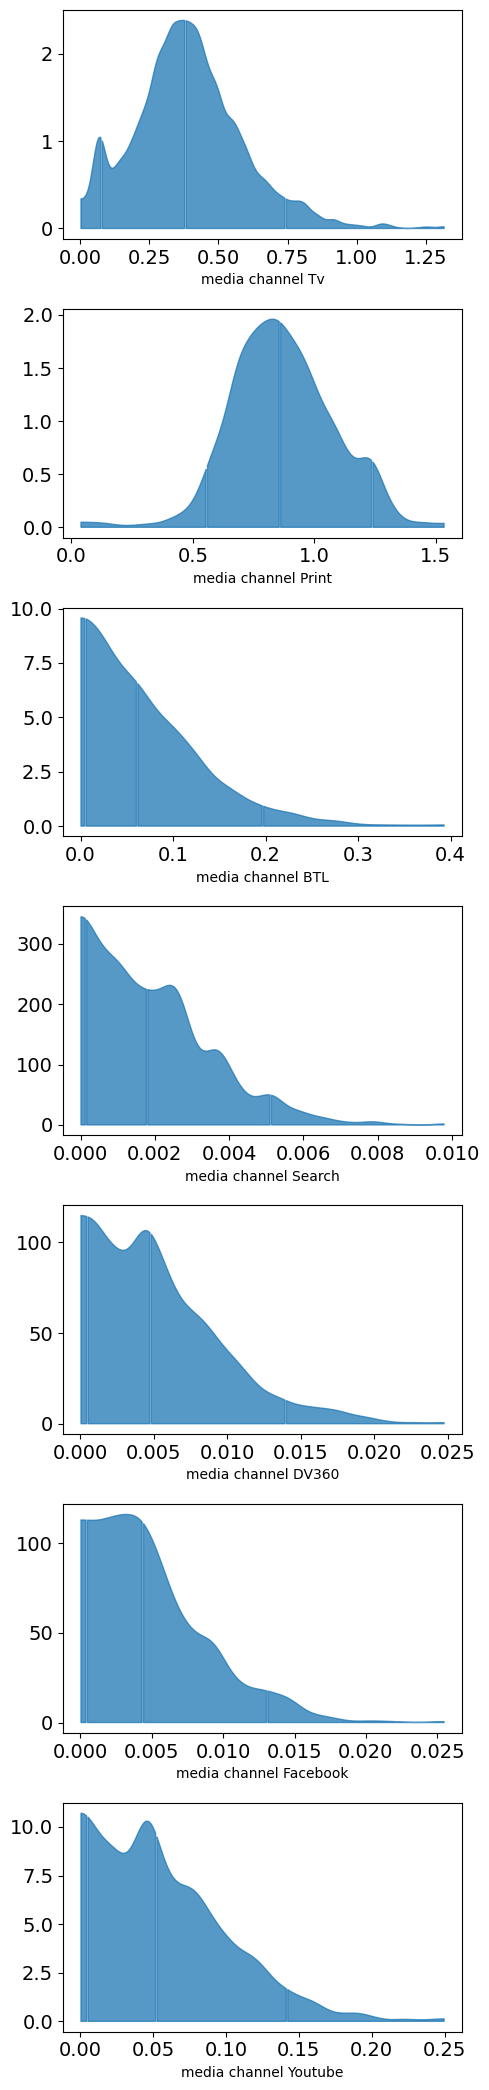

In [35]:
plot.plot_media_channel_posteriors(media_mix_model=mmm,channel_names = channel_names )

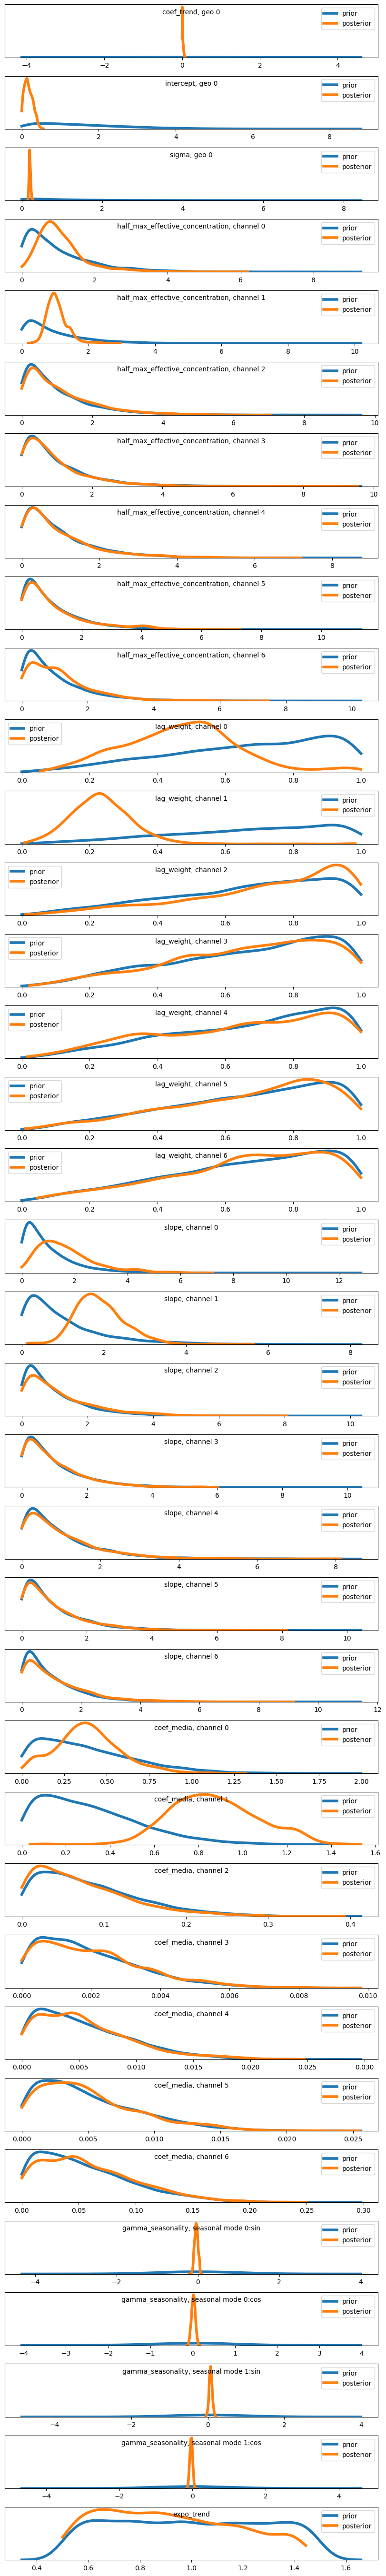

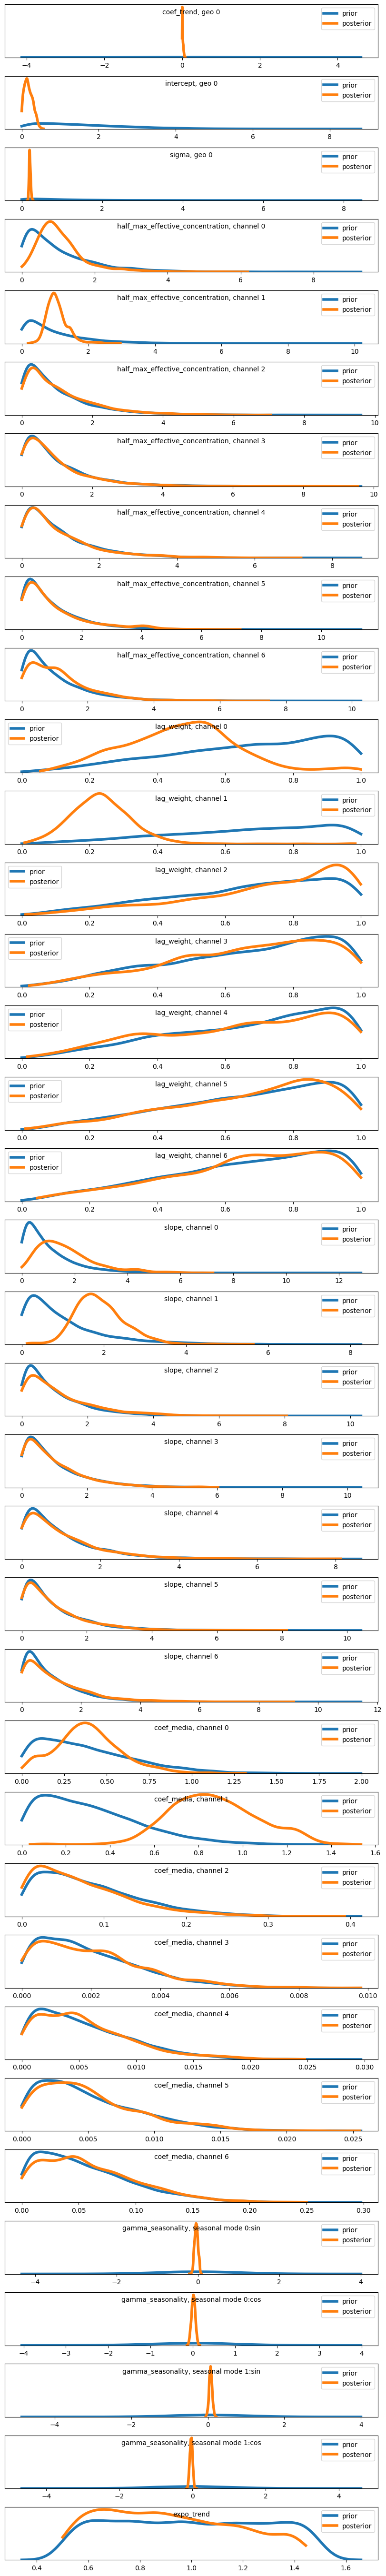

In [36]:
plot.plot_prior_and_posterior(media_mix_model=mmm )

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


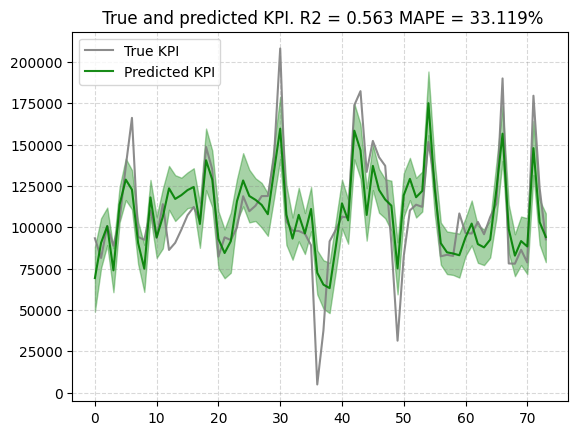

In [37]:

# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"
plot.plot_model_fit(mmm, target_scaler=target_scaler)


In [40]:

# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              seed=SEED)
new_predictions

Array([[0.8475966 , 0.62614447],
       [0.8022753 , 0.7052635 ],
       [0.83792245, 0.70650554],
       ...,
       [0.81903994, 0.70751655],
       [0.9092957 , 0.7445507 ],
       [0.77418095, 0.6805804 ]], dtype=float32)

In [41]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)


In [48]:
channel_names

['Tv', 'Print', 'BTL', 'Search', 'Facebook', 'Youtube', 'Outdoor']

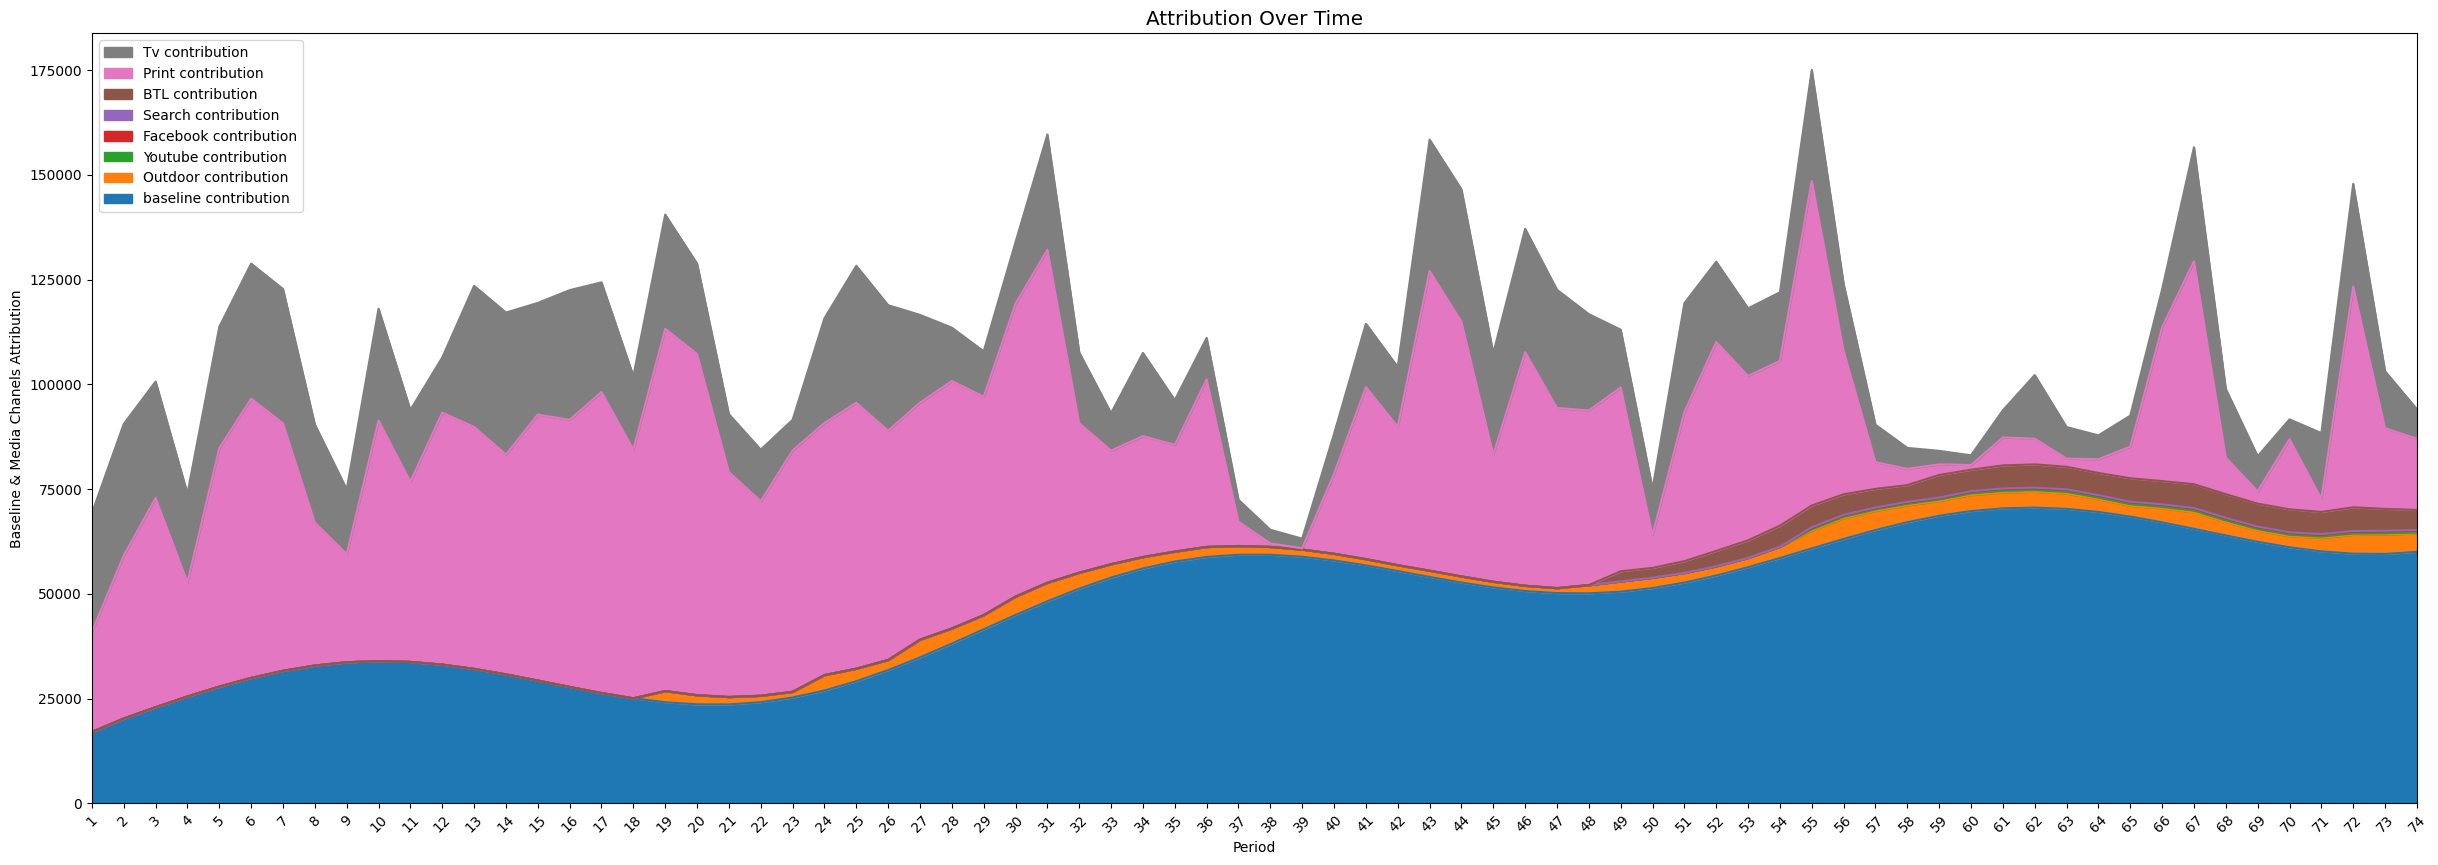

In [49]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,channel_names = channel_names,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

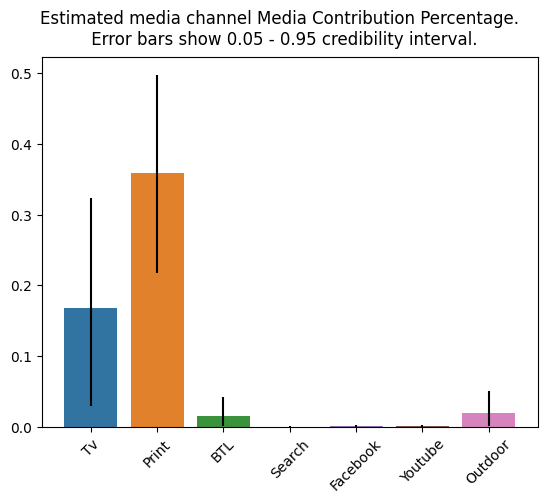

In [50]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage" , channel_names = channel_names)


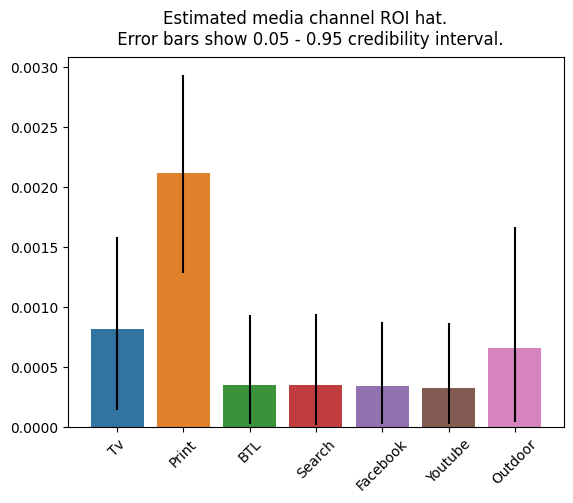

In [51]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat"  , channel_names = channel_names)


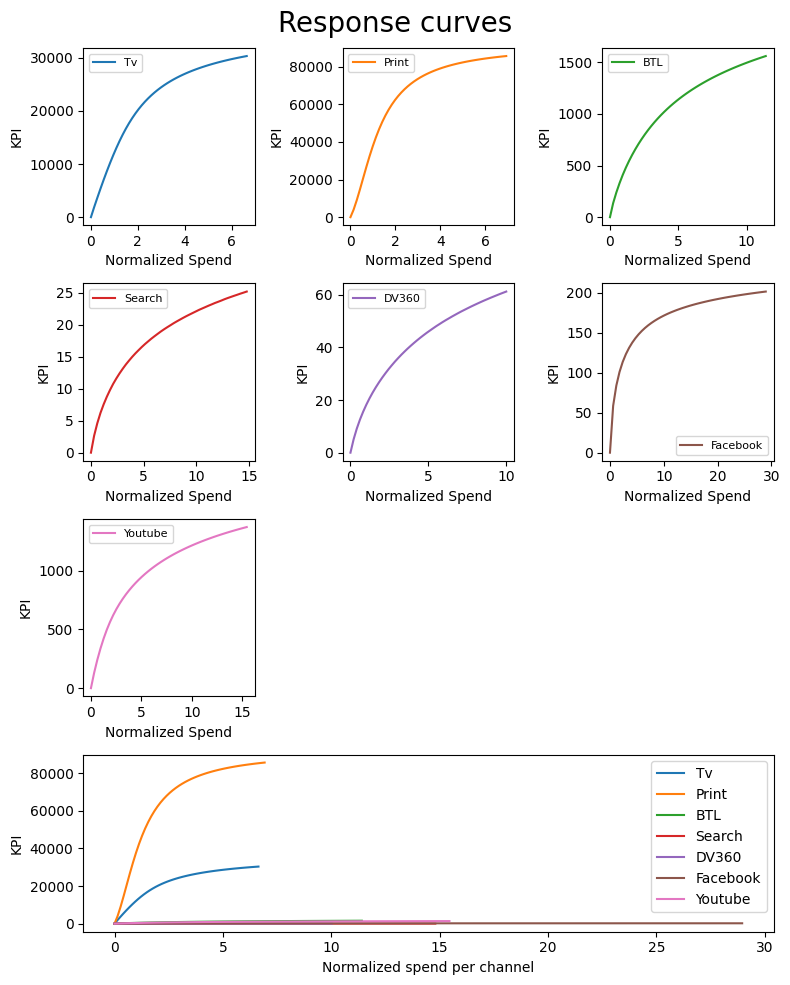

In [52]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)